In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Read data

In [2]:
df_train = pd.read_csv('bitrate_prediction/bitrate_train.csv')
df_test = pd.read_csv('bitrate_prediction/bitrate_test.csv')

# 2. Data Exploration

In [3]:
print('Number of rows and columns in the training data set: ',df_train.shape)
df_train.head(5)

Number of rows and columns in the training data set:  (379021, 10)


,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
0,24.4,0.516398,91.1,6.723921,0.0,0.0,0.0,460.5,7.648529,616.0
1,28.6,2.065591,99.7,15.923777,0.0,0.0,0.0,616.3,155.414893,565.0
2,30.0,0.000000,98.1,11.798776,0.0,0.0,0.0,565.2,9.077445,573.0
3,30.3,0.948683,99.4,13.014522,0.0,0.0,0.0,573.8,28.350191,585.0
4,29.9,0.316228,123.2,62.476307,0.0,0.0,0.0,585.8,59.458295,555.0


In [4]:
types = df_train.dtypes
print("Number categorical featues:", sum(types=='object'))
print(types)

Number categorical featues: 0
fps_mean               float64
fps_std                float64
rtt_mean               float64
rtt_std                float64
dropped_frames_mean    float64
dropped_frames_std     float64
dropped_frames_max     float64
bitrate_mean           float64
bitrate_std            float64
target                 float64
dtype: object


In [5]:
df_train_describe = df_train.describe().T
df_train_describe

,count,mean,std,min,25%,50%,75%,max
fps_mean,379021.0,35.231127,10.975010,10.0,28.800000,30.000000,43.600000,125.800000
fps_std,379021.0,1.725705,2.505942,0.0,0.316228,0.942809,2.233582,307.167273
rtt_mean,379021.0,49.623858,94.781098,0.0,14.300000,32.200000,55.900000,12898.400000
rtt_std,379021.0,12.763672,112.684460,0.0,0.699206,1.433721,4.948625,40721.933293
dropped_frames_mean,379021.0,0.180451,1.732890,0.0,0.000000,0.000000,0.000000,540.000000
dropped_frames_std,379021.0,0.469548,3.157866,0.0,0.000000,0.000000,0.000000,202.385770
dropped_frames_max,379021.0,1.450719,9.670928,0.0,0.000000,0.000000,0.000000,640.000000
bitrate_mean,379021.0,7516.585502,6073.992189,0.0,2773.300000,6287.200000,10187.200000,64913.500000
bitrate_std,379021.0,1603.487501,1721.021623,0.0,383.683550,1112.710010,2241.848801,26908.532303
target,379021.0,7525.396231,6070.817736,0.0,2785.000000,6296.000000,10192.000000,64913.000000


In [6]:
df_train.isna().sum()

fps_mean               0
fps_std                0
rtt_mean               0
rtt_std                0
dropped_frames_mean    0
dropped_frames_std     0
dropped_frames_max     0
bitrate_mean           0
bitrate_std            0
target                 0
dtype: int64

No missing values, all numeric

## 3. Data Preprocessing

#### TrainTest splitting

In [7]:
x_train, y_train, x_test, y_test = df_train.iloc[:, :-1], df_train.iloc[:, -1],\
                                   df_test.iloc[:, :-1], df_test.iloc[:, -1]

print(x_train.shape, x_test.shape)

(379021, 9) (228145, 9)


#### Features Scaling

In [8]:
# function for scaling
def scaler(scaler_name, x_train, x_test):
    """ 
        This function scales our features by using scaler_name method.
        For example, scaler_name can be MinMaxScaler or StandartScaler, or any other.    
    """
    scaler = scaler_name()
    # fit it to the data.
    scaler.fit(x_train)
    # transform the data
    scaled_data_train = pd.DataFrame(scaler.transform(x_train), columns = x_train.columns)
    scaled_data_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

    return scaled_data_train, scaled_data_test

In [9]:
from sklearn.preprocessing import MinMaxScaler


scaled_data_train, scaled_data_test = scaler(MinMaxScaler, x_train, x_test)

## 5. Data Visualization

### PCA

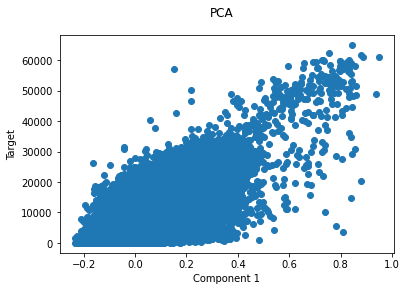

In [10]:
from sklearn.decomposition import PCA

dim_reducer = PCA(n_components=1)
pca_x_train = dim_reducer.fit_transform(scaled_data_train)


plt.scatter(pca_x_train[:,0], y_train)
plt.ylabel('Target')
plt.xlabel('Component 1')

plt.suptitle('PCA')
plt.show()

Text(0.5, 0, 'bitrate_mean')

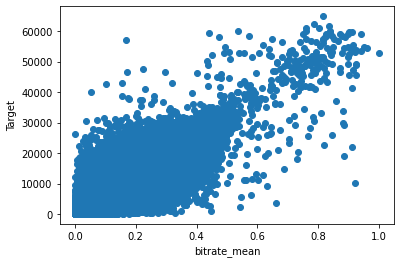

In [11]:
plt.scatter(scaled_data_train['bitrate_mean'], y_train)
plt.ylabel('Target')
plt.xlabel('bitrate_mean')

We can notice that the first PCA component's plot is similar to the above plot. We can assume that feature "bitrate_mean" is playing important role in prediction of bitrate.

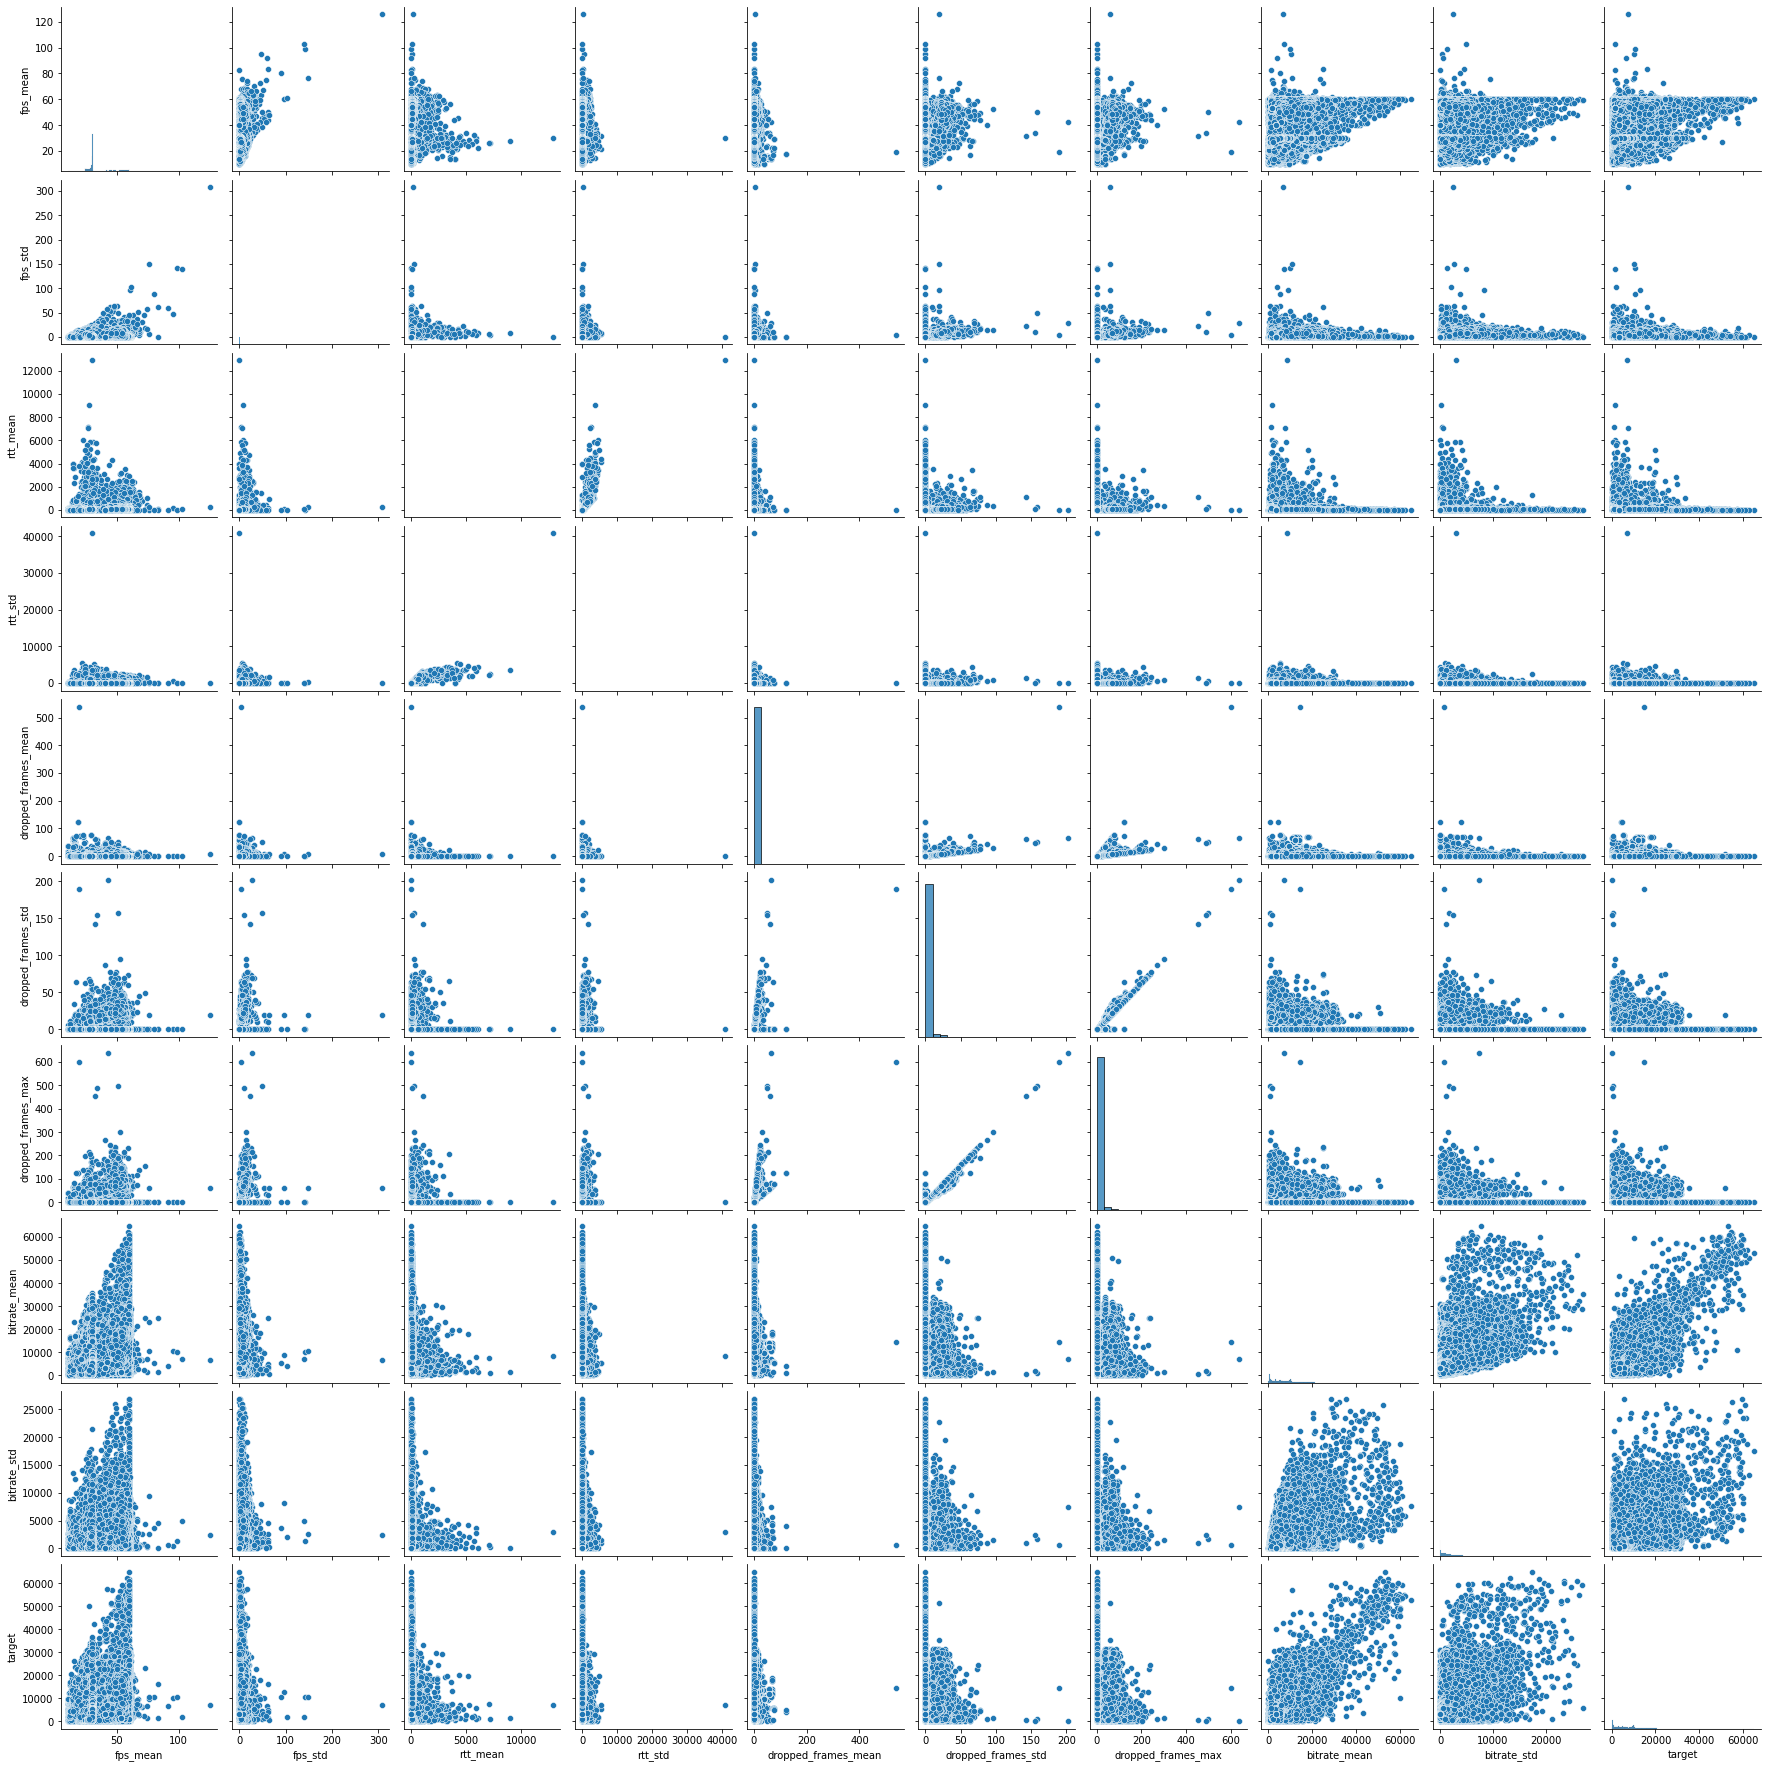

In [24]:
sns.pairplot(df_train)
plt.show()

Here we see that some features have very strong linear relationship with each other, for example "dropped_frames_max" and "dropped_frames_std".
Also we may notice that "fps_std", "rtt_std", "dropped_frames_mean", "dropped_frames_std" and "dropped_frames_max" have weak relationship with target variable, what means that they may have a little impact in prediction. While "bitrate_mean" and "bitrate_std", conversely, have obvious impact to target.

## 6. Feature Selection

In [12]:
len_df = len(scaled_data_train)
unique_vlaues_in_columns = scaled_data_train.nunique()

columns_with_constant_value = scaled_data_train.columns[unique_vlaues_in_columns <= 1]
print("Columns with constant value:", columns_with_constant_value.tolist())

threshold = 0.99
columns_with_distinct_values = scaled_data_train.columns[unique_vlaues_in_columns / len_df > threshold]
print(f"Columns with {threshold * 100} % distinct values: {columns_with_distinct_values.tolist()}")

Columns with constant value: []
Columns with 99.0 % distinct values: []


### Correlation

<AxesSubplot:>

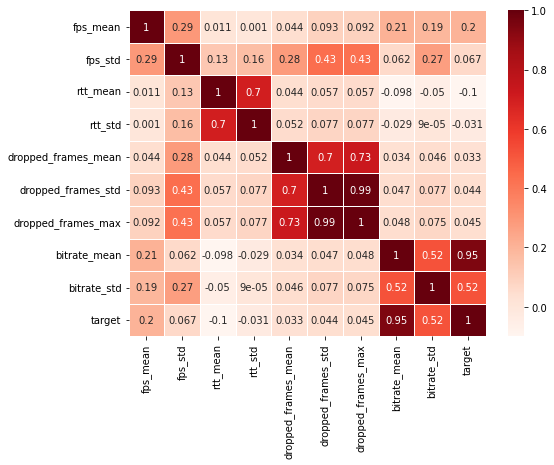

In [13]:
import seaborn as sns


fig, ax = plt.subplots(figsize=(8,6))        
sns.heatmap(df_train.corr(), annot=True, cmap=plt.cm.Reds, linewidths=.5, ax=ax)

### Univariate selection methods - SelectKBest, using Pearson’s Correlation Coefficient 

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# define feature selection
fs = SelectKBest(score_func=f_regression, k=3)
# fit the model
fs.fit(scaled_data_train, y_train)


# print the correlated features
correlated_feature_columns = [
                            x for x in scaled_data_train.columns
                            if x not in scaled_data_train.columns[fs.get_support()]
                         ]
print(f"Amount of dropped feature columns: {len(correlated_feature_columns)}")
    
print(f"Dropped feature columns names:\n {correlated_feature_columns}")

# remaining features
print(f"Remaining features:\n {fs.get_feature_names_out()}")

Amount of dropped feature columns: 6
Dropped feature columns names:
 ['fps_std', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max']
Remaining features:
 ['fps_mean' 'bitrate_mean' 'bitrate_std']


A bar chart of the feature importance scores for each input feature.

Feature 0: 15920.373908370417
Feature 1: 1707.4578493372803
Feature 2: 3833.285589413467
Feature 3: 361.60004401081835
Feature 4: 403.23818096424384
Feature 5: 746.6503422569372
Feature 6: 775.7395301115755
Feature 7: 3168868.682679657
Feature 8: 140064.6636341847


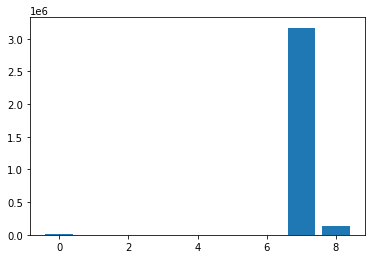

In [15]:
# what are scores for the features
for i in range(len(fs.scores_)):
	print(f'Feature {i}: {fs.scores_[i]}')
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

The plot shows that features 0, 7, and 8 have more impact than the other features. Namely, these features are "fps_mean", "bitrate_mean", and "bitrate_std" accordingly.

### Lasso feature selection

In [16]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(scaled_data_train, y_train)
lasso.coef_

array([   95.01921437,     0.        ,    -0.        ,    -0.        ,
          -0.        ,    -0.        ,    -0.        , 60081.49634367,
        3082.32106882])

As we see Lasso model considered only 3 features as important. And these features are also "fps_mean", "bitrate_mean", and "bitrate_std".
Then remain only these three features in our dataset.

In [17]:
# features, which we want to remain
features = fs.get_feature_names_out()

x_train_reduced = scaled_data_train[features]
x_test_reduced = scaled_data_test[features]

print(f"\nThe shape of reduced training set: {x_train_reduced.shape}")
print(f"The shape of reduced test set: {x_test_reduced.shape}") 


The shape of reduced training set: (379021, 3)
The shape of reduced test set: (228145, 3)


# Machine Learning Models

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [19]:
# function for printing metrics for regression
def performance_measurement_regression(y_test, y_test_prediction, y_train, y_train_prediction):
    """ This function prints MSE, MAE, RMSE and R^2-Score metrics for train and test datasets"""

    print("For Train:")
    print('R^2:', r2_score(y_train, y_train_prediction)) 
    print("Mean Squared Error:", mean_squared_error(y_train, y_train_prediction))
    print("Mean Absolute Error:", mean_absolute_error(y_train, y_train_prediction))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_train_prediction)))

    print("For Test:")
    print('R^2:', r2_score(y_test, y_test_prediction))
    print("Mean Squared Error:", mean_squared_error(y_test, y_test_prediction))
    print("Mean Absolute Error:", mean_absolute_error(y_test, y_test_prediction))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_test_prediction)))

### Linear Regression

In [20]:
def linear_regression_model(x_train, y_train, x_test):
    """Function for fitting and predicting by using linear regression model"""
    
    linear_regressor = LinearRegression()

    #fit the model
    linear_regressor.fit(x_train, y_train)

    # predictions
    y_test_prediction = linear_regressor.predict(x_test)
    y_train_prediction = linear_regressor.predict(x_train)

    return y_test_prediction, y_train_prediction

In [21]:
y_test_prediction_linear_regression, y_train_prediction_linear_reggresion = linear_regression_model(
    x_train_reduced, y_train, x_test_reduced
)

performance_measurement_regression(
    y_test,
    y_test_prediction_linear_regression,
    y_train,
    y_train_prediction_linear_reggresion,
)

For Train:
R^2: 0.8940640578939879
Mean Squared Error: 3904240.622346417
Mean Absolute Error: 1097.0729147549805
Root Mean Squared Error: 1975.915135411037
For Test:
R^2: 0.8934080213486484
Mean Squared Error: 3801141.850736365
Mean Absolute Error: 1076.9550513092104
Root Mean Squared Error: 1949.651725497753


### Ridge Regression

In [22]:
def find_alpha_Ridge(x_train, y_train, x_val, y_val):
    """Function for tuning parameter alpha for ridge regression"""

    alphas = [2.2, 2, 1.5, 1.3, 1.2, 1.1, 1, 0.3, 0.1]
    losses = []
    for alpha in alphas:
        ridge = Ridge(alpha = alpha)
        ridge.fit(x_train, y_train)
        y_pred_val = ridge.predict(x_val)

        mse = mean_squared_error(y_val, y_pred_val)
        losses.append(mse)

    best_alpha = alphas[np.argmin(losses)]
    return best_alpha

In [23]:
def Ridge_regression_model(x_train, y_train, x_test):
    """Function for fitting and predicting by using Ridge regression model"""

    # Splitting training set on train and validation for tuninug the parameter alpha.
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/8, random_state=123)

    # finding the best alpha for model
    alpha = find_alpha_Ridge(x_train, y_train, x_val, y_val)

    # creating a model
    ridge_regressor = Ridge(alpha = alpha)

    #fit the model
    ridge_regressor.fit(x_train, y_train)

    # predictions
    y_test_prediction = ridge_regressor.predict(x_test)
    y_train_prediction = ridge_regressor.predict(x_train)

    performance_measurement_regression(y_test, y_test_prediction, y_train, y_train_prediction)

    return y_test_prediction, y_train_prediction

In [24]:
y_test_prediction_ridge, y_train_prediction_ridge = Ridge_regression_model(x_train_reduced, y_train, x_test_reduced)

For Train:
R^2: 0.8940479794915754
Mean Squared Error: 3910886.4924790845
Mean Absolute Error: 1097.2376063667998
Root Mean Squared Error: 1977.5961398827326
For Test:
R^2: 0.8934080535216087
Mean Squared Error: 3801140.703426902
Mean Absolute Error: 1077.1409155925883
Root Mean Squared Error: 1949.6514312632662


### Lasso

In [25]:
def find_alpha_Lasso(x_train, y_train, x_val, y_val):
    """Function for tuning parameter alpha for Lasso regression"""

    alphas = [2.2, 2, 1.5, 1.3, 1.2, 1.1, 1, 0.3, 0.1]
    losses = []
    for alpha in alphas:
        lasso = Lasso(alpha = alpha)
        lasso.fit(x_train, y_train)
        y_pred_val = lasso.predict(x_val)

        mse = mean_squared_error(y_val, y_pred_val)
        losses.append(mse)

    best_alpha = alphas[np.argmin(losses)]
    return best_alpha

In [26]:
def Lasso_regression_model(x_train, y_train, x_test):
    """Function for fitting and predicting by using Lasso regression model"""

    # creating a validation set for tuning alpha
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/8, random_state=123)

    # finding the best alpha for model
    alpha = find_alpha_Lasso(x_train, y_train, x_val, y_val)

    # creating a model
    ridge_regressor = Lasso(alpha = alpha)

    #fit the model
    ridge_regressor.fit(x_train, y_train)

    # predictions
    y_test_prediction = ridge_regressor.predict(x_test)
    y_train_prediction = ridge_regressor.predict(x_train)

    performance_measurement_regression(y_test, y_test_prediction, y_train, y_train_prediction)

    return y_test_prediction, y_train_prediction

In [27]:
y_test_prediction_lasso, y_train_prediction_lasso = Lasso_regression_model(x_train_reduced, y_train, x_test_reduced)

For Train:
R^2: 0.8940472265328991
Mean Squared Error: 3910914.2855867813
Mean Absolute Error: 1097.8759210851756
Root Mean Squared Error: 1977.6031668630542
For Test:
R^2: 0.8934085644163684
Mean Squared Error: 3801122.484575191
Mean Absolute Error: 1077.7160564971969
Root Mean Squared Error: 1949.6467589220338


### Polynomial Regression

In [28]:
def polynomial_regression_model(x_train, y_train, x_test, degree):
    """Function for fitting and predicting by using polynomial regression"""

    polynomial_features = PolynomialFeatures(degree=degree)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(x_train, y_train)

    # predicting on training data-set
    y_train_prediction = pipeline.predict(x_train)

    # predicting on test data-set
    y_test_prediction = pipeline.predict(x_test)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, x_train, y_train,
                             scoring="neg_mean_squared_error", cv=10)
    
    return y_test_prediction, y_train_prediction    

In [29]:
degree = [2, 4, 5] 
for i in degree:
    y_test_prediction_poly, y_train_prediction_poly = polynomial_regression_model(x_train_reduced, y_train, x_test_reduced, i)
    print(f"Degree = {i}")
    performance_measurement_regression(y_test, y_test_prediction_poly, y_train, y_train_prediction_poly)

Degree = 2
For Train:
R^2: 0.8952034835452649
Mean Squared Error: 3862247.3967666817
Mean Absolute Error: 1070.2506389978657
Root Mean Squared Error: 1965.2601346301924
For Test:
R^2: 0.8940912184338407
Mean Squared Error: 3776778.581889282
Mean Absolute Error: 1054.3825715361886
Root Mean Squared Error: 1943.3935735947266
Degree = 4
For Train:
R^2: 0.8957754881760649
Mean Squared Error: 3841166.320114676
Mean Absolute Error: 1064.6284759272392
Root Mean Squared Error: 1959.8893642536755
For Test:
R^2: 0.8936654833896329
Mean Squared Error: 3791960.5807069982
Mean Absolute Error: 1051.923847178126
Root Mean Squared Error: 1947.295709620652
Degree = 5
For Train:
R^2: 0.8960139308382199
Mean Squared Error: 3832378.580003255
Mean Absolute Error: 1065.560007449355
Root Mean Squared Error: 1957.646183559035
For Test:
R^2: 0.8933097262343073
Mean Squared Error: 3804647.120809895
Mean Absolute Error: 1053.4599732830852
Root Mean Squared Error: 1950.550466101786


We see that model with degree = 4 gives us the best results comparing to Linear, Lasso, and Ridge regressions.

# Outlier Detection

In [30]:
from sklearn.neighbors import LocalOutlierFactor


lof = LocalOutlierFactor()
yhat = lof.fit_predict(x_train)

# select all rows that are not outliers
mask = yhat != -1
x_train_without_outliers, y_train_without_outliers = x_train[mask], y_train[mask]

Counting the percentage of outliers

In [31]:
unique_values, counts = np.unique(yhat, return_counts = True)
print(f"Unique values: {unique_values}, Amount accordingly: {counts}")

percentage =  counts[0] / len(x_train) * 100
print(f"The percentage of outliers is {percentage:.2f}%")

Unique values: [-1  1], Amount accordingly: [ 14636 364385]
The percentage of outliers is 3.86%


In [32]:
# scaling
scaled_train_without_outliers, scaled_test = scaler(MinMaxScaler,x_train_without_outliers, x_test)

# reducing the same features
x_train_reduced_without_outliers = scaled_train_without_outliers[features]
x_test_reduced = scaled_test[features]

# linear regression
y_test_pred_without_outliers, y_train_pred_without_outliers = linear_regression_model(
    x_train_reduced_without_outliers, y_train_without_outliers, x_test_reduced
)

performance_measurement_regression(
    y_test,
    y_test_pred_without_outliers,
    y_train_without_outliers,
    y_train_pred_without_outliers,
)

For Train:
R^2: 0.8946422189642103
Mean Squared Error: 3919587.4694858985
Mean Absolute Error: 1101.2677593434187
Root Mean Squared Error: 1979.7948048941582
For Test:
R^2: 0.893402496938707
Mean Squared Error: 3801338.8549208674
Mean Absolute Error: 1077.526647618693
Root Mean Squared Error: 1949.7022477601208


Removing outliers didn't improve our results, conversely MAE became higher. It may be because not all removed data could be outliers, it could be just high variance feature, then we removed important value, what leaded us to metrics increasement.